# **APIs**

API stands for Application Program Interface and is a way for two or more computer programmes to communicate with each other.

REST (Representational State Transfer) APIs allow communication between a client (your program) and a server (usually online) using HTTP (HyperText Transfer Protocol) to communicate.

A HTTP request is sent from client to server containing the instructions in a file (usually .json). The server then executes the instructions and sends a HTTP response which contains the result.

Let's look at an example.

In [201]:
import requests
import json
import pandas

We first define the HTTP request providing the appropriate URL.

In [202]:
country = 'Italy'
daterange = '20211215-20220115'
url = ( 'https://covidmap.umd.edu/api/resources?indicator=covid&type=smoothed&country=' +
    country + '&daterange=' + daterange )

We then send request via API and collect the text response using the `get()` function.

In [203]:
response = requests.get(url)
print(response)

<Response [200]>


We can get a number of API responses the key ones to remember are:

*   200 - success
*   400 - bad request (i.e., the error is in our code)
*   500 - internal server error (i.e., the error is on the server side)


We then transform the text response in a json file. a json is a JavaScript Object Notation consisting of name-object pairs and punctuation in the form of brackets, parentheses, semicolons and colons (basically a big dictionary!)

In [204]:
jsonData = json.loads(response.text)
print(jsonData)

{'data': [{'smoothed_pct_covid': 0.008273, 'smoothed_covid_se': 0.000746, 'sample_size': 23576.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': 'ITA', 'survey_date': '20211215'}, {'smoothed_pct_covid': 0.00833, 'smoothed_covid_se': 0.000705, 'sample_size': 25805.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': 'ITA', 'survey_date': '20211216'}, {'smoothed_pct_covid': 0.008428, 'smoothed_covid_se': 0.00073, 'sample_size': 25625.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': 'ITA', 'survey_date': '20211217'}, {'smoothed_pct_covid': 0.009292, 'smoothed_covid_se': 0.000849, 'sample_size': 25439.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': 'ITA', 'survey_date': '20211218'}, {'smoothed_pct_covid': 0.009478, 'smoothed_covid_se': 0.000884, 'sample_size': 24049.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': 'ITA', 'survey_date': '20211219'}, {'smoothed_pct_covid': 0.009137, 'smoothed_covid_se': 0.000853, 'sample_size': 24124.0, 'country': 'Italy', 'iso_code': 'ITA', 'gid_0': '

And lastly convert the json to a pandas dataframe - ready for us to use.

In [205]:
df = pandas.DataFrame.from_dict(jsonData['data'])
df.head()

,smoothed_pct_covid,smoothed_covid_se,sample_size,country,iso_code,gid_0,survey_date
0,0.008273,0.000746,23576.0,Italy,ITA,ITA,20211215
1,0.008330,0.000705,25805.0,Italy,ITA,ITA,20211216
2,0.008428,0.000730,25625.0,Italy,ITA,ITA,20211217
3,0.009292,0.000849,25439.0,Italy,ITA,ITA,20211218
4,0.009478,0.000884,24049.0,Italy,ITA,ITA,20211219


## **Using World Bank Data API**

You can find the documentation on the API interface and practical examples [here](https://wbdata.readthedocs.io/en/stable/) and [here](https://blogs.worldbank.org/opendata/accessing-world-bank-data-apis-python-r-ruby-stata) respectively.

Let's replicate the example code below.

We first need to install the `wbdata` library which contains the API call.

In [206]:
!pip3 install -U wbdata

We then import the libraries.

In [207]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The `get_country()` function gives us a list of all countries.  

In [208]:
wbdata.get_countries()

id    name
----  --------------------------------------------------------------------------------
ABW   Aruba
AFE   Africa Eastern and Southern
AFG   Afghanistan
AFR   Africa
AFW   Africa Western and Central
AGO   Angola
ALB   Albania
AND   Andorra
ARB   Arab World
ARE   United Arab Emirates
ARG   Argentina
ARM   Armenia
ASM   American Samoa
ATG   Antigua and Barbuda
AUS   Australia
AUT   Austria
AZE   Azerbaijan
BDI   Burundi
BEA   East Asia & Pacific (IBRD-only countries)
BEC   Europe & Central Asia (IBRD-only countries)
BEL   Belgium
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BHI   IBRD countries classified as high income
BHR   Bahrain
BHS   Bahamas, The
BIH   Bosnia and Herzegovina
BLA   Latin America & the Caribbean (IBRD-only countries)
BLR   Belarus
BLZ   Belize
BMN   Middle East & North Africa (IBRD-only countries)
BMU   Bermuda
BOL   Bolivia
BRA   Brazil
BRB   Barbados
BRN   Brunei Darussalam
BSS   Sub-Saharan Africa (IBRD-only countries)
BTN   Bhutan
BWA  

We can pick the countries that interest us.

In [209]:
countries = ["USA","GBR","ITA"]

The `get_indicator()` function gives us a list of all indicators.

In [210]:
wbdata.get_indicators()

id                                                 name
-------------------------------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0.HCount.1.90usd                                 Poverty Headcount ($1.90 a day)
1.0.HCount.2.5usd                                  Poverty Headcount ($2.50 a day)
1.0.HCount.Mid10to50                               Middle Class ($10-50 a day) Headcount
1.0.HCount.Ofcl                                    Official Moderate Poverty Rate-National
1.0.HCount.Poor4uds                                Poverty Headcount ($4 a day)
1.0.HCount.Vul4to10                                Vulnerable ($4-10 a day) Headcount
1.0.PGap.1.90usd                                   Poverty Gap ($1.90 a day)
1.0.PGap.2.5usd      

We can choose the indicator that we want.

In [211]:
indicators = {'NY.GNP.PCAP.CD':'GNI per Capita'}

We then make the call using the country and indicators parameters.

In [212]:
df = wbdata.get_dataframe(indicators, country=countries, parse_dates=False)

The df is given as a pivot table. Pandas' `.unstack()` method helps reshape it into something plottable.

In [213]:
dfu = df.unstack(level=0)
dfu

GNI per Capita                             
country          Italy United Kingdom United States
date                                               
1960               NaN            NaN           NaN
1961               NaN            NaN           NaN
1962             960.0            NaN        3280.0
1963            1060.0            NaN        3410.0
1964            1160.0            NaN        3610.0
...                ...            ...           ...
2018           33850.0        42020.0       63460.0
2019           34910.0        43240.0       66130.0
2020           32440.0        38750.0       64650.0
2021           36420.0        45550.0       70900.0
2022           38200.0        49240.0       76770.0

[63 rows x 3 columns]

We can now plot the GNI for the selected countries.

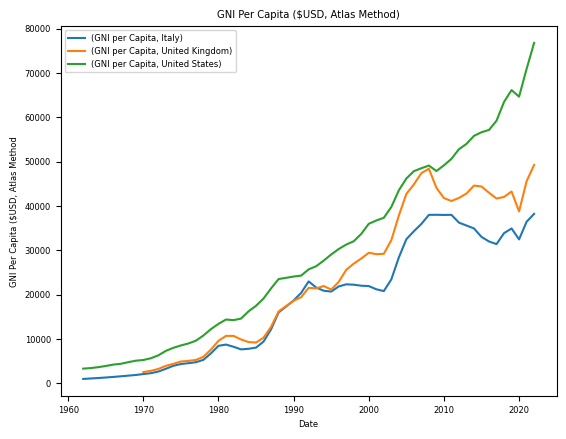

In [214]:
dfu.plot();
plt.legend(loc='best');
plt.title("GNI Per Capita ($USD, Atlas Method)");
plt.xlabel('Date');
plt.ylabel('GNI Per Capita ($USD, Atlas Method');

We can also plot two indicators together if we want to compare their trends.
Let us see the relationship between GDP and population un China.

We first select the country and indicators of interest.

In [215]:
chn = ['CHN']
gdp_indicator = {'NY.GDP.PCAP.CD':'GDP'}
pop_indicator = {'SP.POP.TOTL':'POP'}

Then get the data by calling the World Bank Data API.

In [216]:
gdp = wbdata.get_dataframe(gdp_indicator, country=chn, parse_dates=False)
pop = wbdata.get_dataframe(pop_indicator , country=chn, parse_dates=False)

To make the two indicators comparable in out plot we standardise them.

In [217]:
gdp = (gdp-gdp.mean())/gdp.std()
pop = (pop-pop.mean())/pop.std()

And then make sure that years are in the right order.

In [218]:
gdp = gdp.sort_index(ascending=True)
pop = pop.sort_index(ascending=True)

We then plot the two indicators.

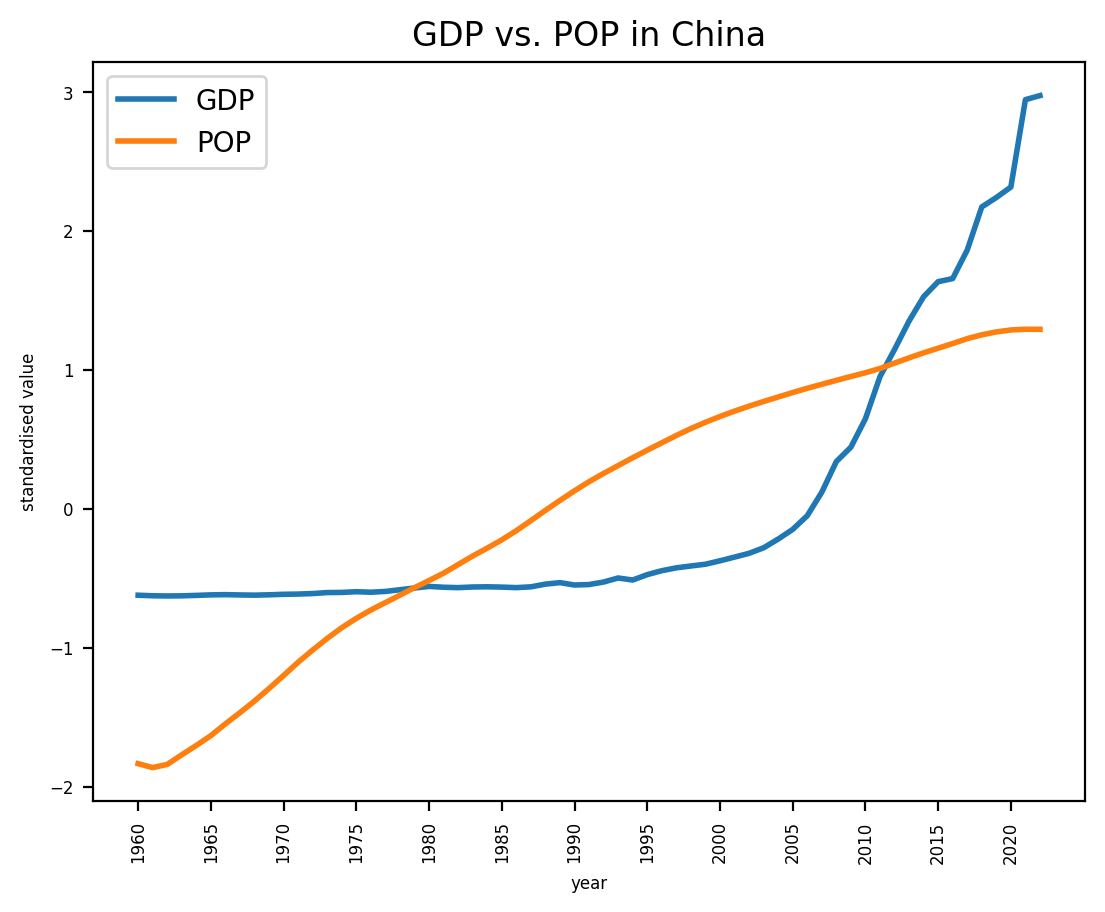

In [219]:
fig, ax = plt.subplots(dpi=200)
plt.rcParams.update({'font.size': 10})
fig.subplots_adjust(wspace=0)
ax.plot(gdp, linewidth=2.0, label='GDP')
ax.plot(pop, linewidth=2.0, label='POP')
plt.xticks(rotation='vertical')
plt.xticks(np.arange(0, 61, 5))
plt.title('GDP vs. POP in China');
plt.xlabel('year');
plt.ylabel('standardised value');
plt.legend()

# **Exercise**

Dowload the first 10000 violent incidents acorss the world reported in 2020 by the Uppsala Conflict Data Program and create plots as indicated, following examples in the past tutorials and examples contained in the plotting_example.ipynb file.

1. Familiarize youself with the API documentation, formulate a query to download the data and return the response as a dataframe following the example above.

2. After checking that you have dowloaded the data correctly and what information is available, create a barchart reporting violent incidents by country.

3. Create a second barchart like the one above but using colours to differenciate types of violence. Make sure a legend and labels are present.

4. Side by side, create three histograms reporting the ditribution of violent incidents by type of violence in the sample population of countries.

**Exercise 1**

In [220]:
url = ('https://ucdpapi.pcr.uu.se/api/gedevents/23.1?pagesize=50000&StartDate=2020-01-01&EndDate=2020-12-31')
response = requests.get(url)
print(response)
jsonData = json.loads(response.text)
print(jsonData)
df = pandas.DataFrame.from_dict(jsonData['Result'])
df.head()

<Response [200]>


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,320838,SYR-2020-1-11973-0,2020,True,Clear,1,299,299,Syria: Government,11973,...,2020-01-01T00:00:00,0,0,12,0,12,12,12,652,None
1,320874,SYR-2020-1-11973-5,2020,True,Clear,1,299,299,Syria: Government,11973,...,2020-01-01T00:00:00,2,0,0,0,2,2,2,652,None
2,320875,AFG-2020-2-14637-1,2020,True,Clear,2,14637,13616,IS - SDF,14637,...,2020-01-01T00:00:00,0,0,1,0,1,1,1,None,None
3,320896,SYR-2020-3-14200-0,2020,False,Clear,3,4456,13299,Syrian insurgents - Civilians,4456,...,2020-01-01T00:00:00,0,0,1,0,1,1,1,None,None
4,320897,AFG-2020-2-14637-0,2020,True,Clear,2,14637,13616,IS - SDF,14637,...,2020-01-01T00:00:00,1,0,0,0,1,1,1,None,None


In [221]:
df.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

Create an histogram with incidents by country.

**Exercise 2**

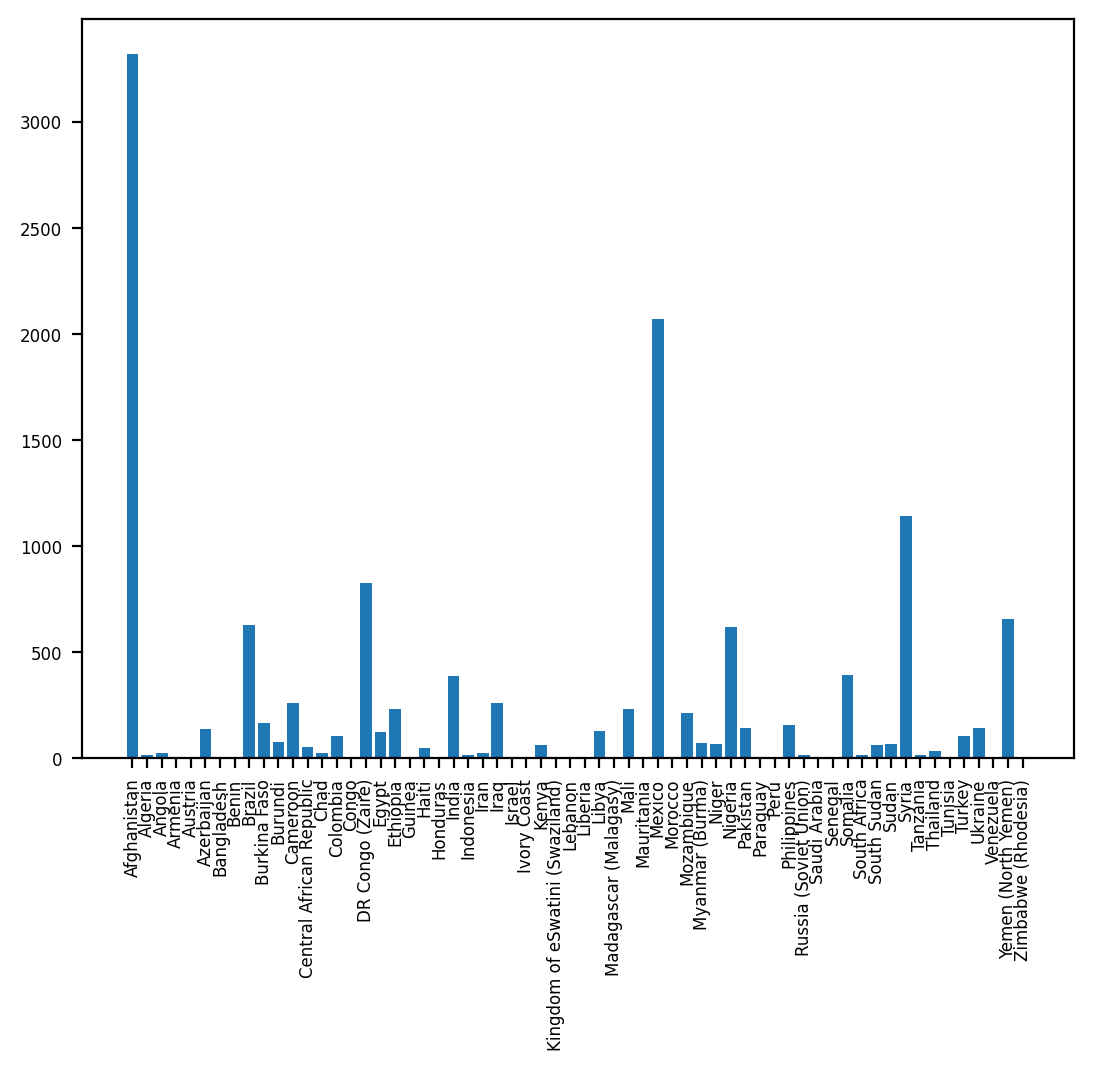

In [222]:
countries, numSurveysInCountry = np.unique(df.country,return_counts=True)
dummy = range(len(countries))

plt.figure(dpi=200)
plt.rcParams.update({'font.size': 6})
plt.bar(dummy,numSurveysInCountry, align='center')
plt.xticks(dummy, countries)
plt.xticks(rotation = 90)
plt.show()

**Exercise 3**

In [223]:
incidents = df.groupby(['country'])['type_of_violence'].value_counts().unstack(fill_value=0)
incidents

type_of_violence,1,2,3
country,,,
Afghanistan,3145,1,171
Algeria,17,0,0
Angola,18,0,8
Armenia,8,0,0
Austria,0,0,1
...,...,...,...
Turkey,103,0,3
Ukraine,145,0,0
Venezuela,0,0,4


In [224]:
type_1 = incidents.loc[:,1]
type_2 = incidents.loc[:,2]
type_3 = incidents.loc[:,3]
countries = np.unique(df.country)
dummy = range(len(countries))

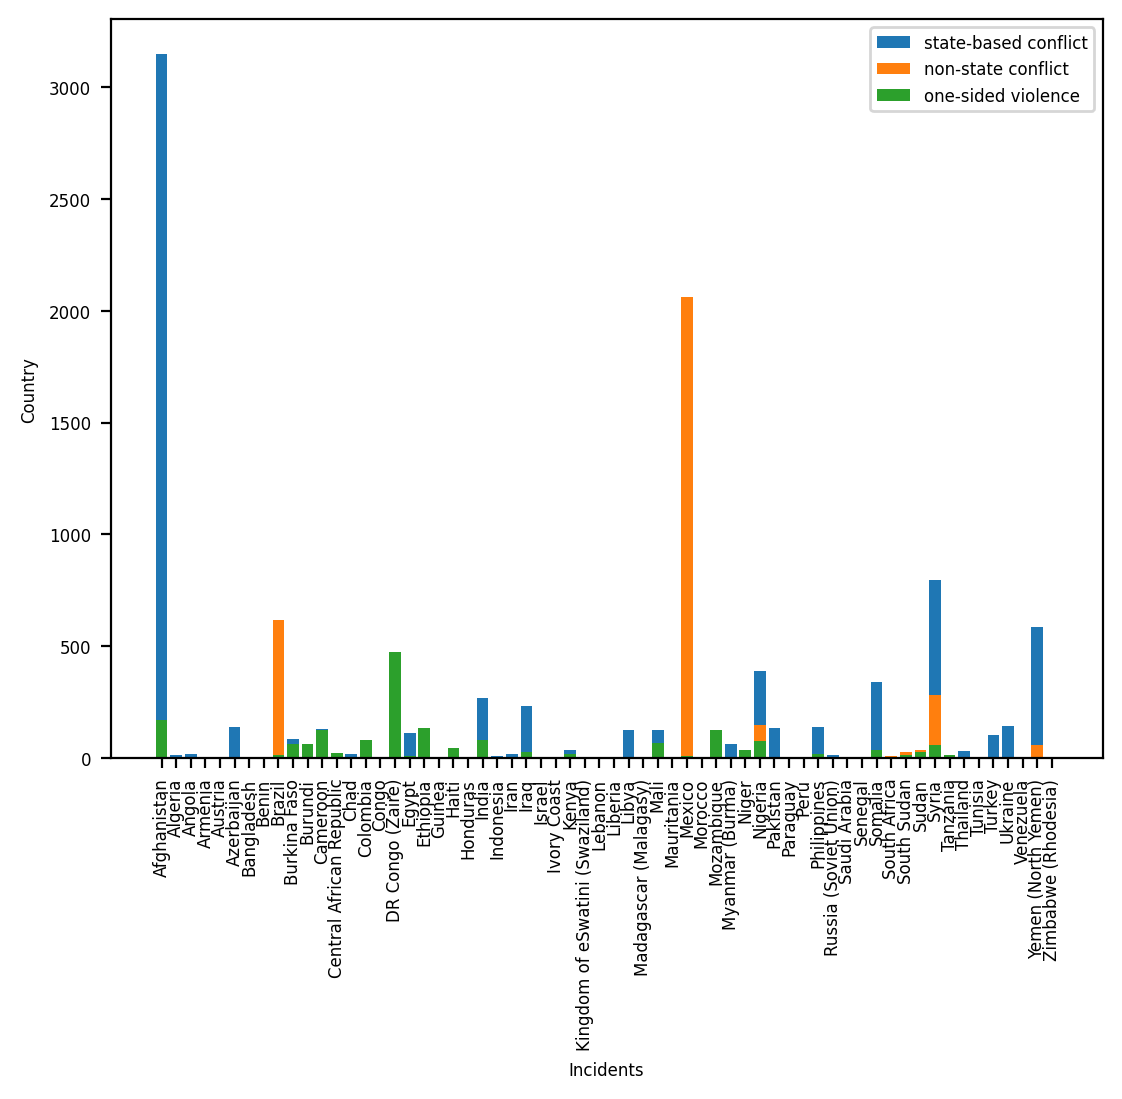

In [225]:
fig, ax = plt.subplots(dpi=200)
ax.bar(dummy, type_1, linewidth=2.0, label = 'state-based conflict')
ax.bar(dummy, type_2, linewidth=2.0, label = 'non-state conflict')
ax.bar(dummy, type_3, linewidth=2.0, label = 'one-sided violence')
ax.set(xticks=np.arange(1, len(dummy)+1))
plt.xlabel('Incidents')
plt.ylabel('Country')
plt.xticks(dummy, countries)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

**Exercise 4**

In [226]:
incidents=pd.DataFrame(incidents.unstack()).reset_index()
incidents.rename(columns={0:'count'}, inplace=True)

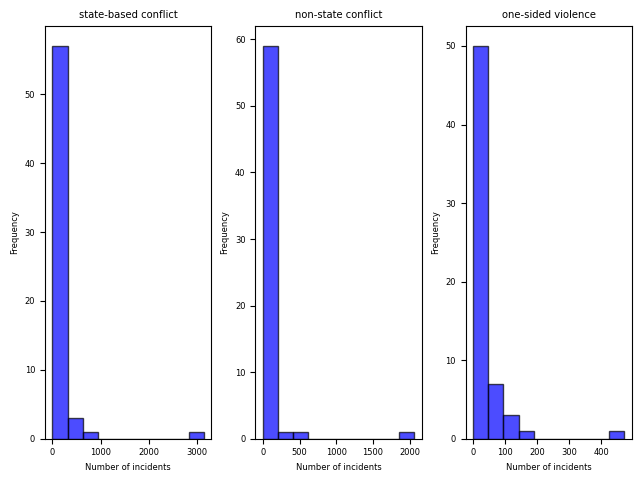

In [227]:
violence_name = {1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'}
types_of_violence = incidents['type_of_violence'].unique()
for i, type_of_violence in enumerate(types_of_violence):
    plt.subplot(1, len(types_of_violence), i + 1)
    plt.hist(incidents[incidents['type_of_violence'] == type_of_violence]['count'], bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title(violence_name[type_of_violence])
    plt.xlabel('Number of incidents')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()